# Recreates GAN model in Chapter 4 of "Generative Deep Learning" by Foster (Ganimals)

# Get Quickdraw "Ganimals" data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

from google.colab import drive

import torch
from torch.nn.modules.transformer import Transformer
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [2]:
# download camel numpy file from Google quickdraw https://bit.ly/30HyNqg
drive.mount('/content/drive/')
data = np.load('/content/drive/My Drive/Data/camel/full_numpy_bitmap_camel.npy')
print(f'Number of images: {data.shape[0]}')
print(f'Shape of images: {data[0].shape}')



Mounted at /content/drive/
Number of images: 121399
Shape of images: (784,)


In [3]:

class ganimal_data(Dataset):
    def __init__(self, np_array, transform=None):
        self.images = np_array
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, i):
        img = self.images[i].reshape((28,28))
        if self.transform:
            img = self.transform(img)
        return (2 * img / 1) - 1 # scale [0,1] to [-1,1]
        return img


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(28),
])

trn_dataset = ganimal_data(data, transform)
trn_dataloader = DataLoader(trn_dataset, batch_size=64, shuffle=True, num_workers=1)

# Visualize images

num images: 121399
shape of each images: torch.Size([1, 28, 28])


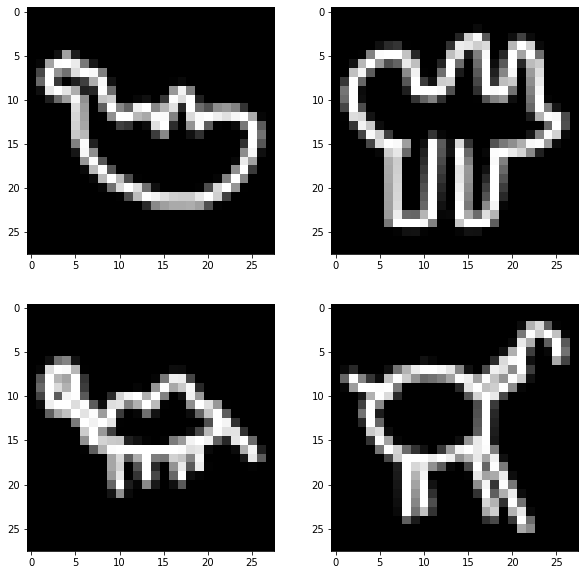

In [5]:
images_iter = iter(trn_dataloader)
images = next(images_iter)

print(f'num images: {len(trn_dataset)}')
print(f'shape of each images: {images[0].shape}' )

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].imshow(images[0].squeeze(0), cmap='gray')
ax[0,1].imshow(images[1].squeeze(0), cmap='gray')
ax[1,0].imshow(images[2].squeeze(0), cmap='gray')
ax[1,1].imshow(images[3].squeeze(0), cmap='gray')
plt.show()


# Model architecture for Discriminator




In [7]:

class Discriminator(nn.Module):

  def __init__(self, in_channels, out_channels, disc_conv_filters, 
               disc_conv_strides, disc_conv_padding, dropout):
     super(Discriminator, self).__init__()
     self.conv1 = nn.Conv2d(in_channels, out_channels[0], kernel_size=disc_conv_filters[0], 
                       stride=disc_conv_strides[0], padding=disc_conv_padding[0])
     self.conv2 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=disc_conv_filters[1], 
                       stride=disc_conv_strides[1], padding=disc_conv_padding[0])
     self.conv3 = nn.Conv2d(out_channels[1], out_channels[2], kernel_size=disc_conv_filters[2], 
                       stride=disc_conv_strides[2], padding=disc_conv_padding[0])     
     self.conv4 = nn.Conv2d(out_channels[2], out_channels[3], kernel_size=disc_conv_filters[3], 
                       stride=disc_conv_strides[3], padding=disc_conv_padding[0]) 
     self.flat = nn.Flatten()   
     self.linear = nn.Linear(2048, 1) 
     self.dropout = nn.Dropout(dropout)


  def forward(self, x):
    x = self.dropout(torch.relu(self.conv1(x)))
    x = self.dropout(torch.relu(self.conv2(x)))
    x = self.dropout(torch.relu(self.conv3(x)))
    x = self.dropout(torch.relu(self.conv4(x)))
    x = self.flat(x)
    x = torch.sigmoid(self.linear(x))
    return x



disc_conv_filters = [5,5,5,5]
disc_conv_strides = [2,2,2,1]
disc_conv_channels = [64, 64, 128, 128]
disc_conv_padding = [2,1,1,1]
dropout=0.4
disc_in_channels=1
torch.random.manual_seed(10210)

my_discriminator = Discriminator(in_channels=disc_in_channels, 
                                 out_channels=disc_conv_channels, 
                                 disc_conv_filters=disc_conv_filters, 
                                 disc_conv_strides=disc_conv_strides,
                                 disc_conv_padding=disc_conv_padding, 
                                 dropout=dropout)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
my_discriminator.to(device)

summary(my_discriminator, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
           Dropout-2           [-1, 64, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]         102,464
           Dropout-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 4, 4]         204,928
           Dropout-6            [-1, 128, 4, 4]               0
            Conv2d-7            [-1, 128, 4, 4]         409,728
           Dropout-8            [-1, 128, 4, 4]               0
           Flatten-9                 [-1, 2048]               0
           Linear-10                    [-1, 1]           2,049
Total params: 720,833
Trainable params: 720,833
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 2.75
Estimated T

In [10]:
class Generator(nn.Module):
  def __init__(self, input_dim, gen_conv_filters, gen_conv_strides, 
               gen_conv_channels, gen_conv_padding, gen_upsample, dropout, momentum, initial_image_size):
      super(Generator, self).__init__()
      self.initial_image_size=initial_image_size
      self.linear1 = nn.Linear(input_dim, 3136)
      self.batch_norm1 = nn.BatchNorm1d(3136, momentum=momentum)
      self.upsample1 = nn.Upsample((gen_initial_size*gen_upsample[0], 
                                    gen_initial_size*gen_upsample[0]))
      self.conv2 = nn.Conv2d(64, gen_conv_channels[0], kernel_size=gen_conv_filters[0], 
                             stride=gen_conv_strides[0], 
                             padding=gen_conv_padding[0])
      self.batch_norm2 = nn.BatchNorm2d(gen_conv_channels[0], momentum=momentum)
      self.upsample2 = nn.Upsample((28,28))
      self.conv3 = nn.Conv2d(gen_conv_channels[0], gen_conv_channels[1], kernel_size=gen_conv_filters[1], 
                             stride=gen_conv_strides[1], 
                             padding=gen_conv_padding[1])
      self.batch_norm3 = nn.BatchNorm2d(gen_conv_channels[1], momentum=momentum)
      self.conv4 = nn.Conv2d(gen_conv_channels[1], gen_conv_channels[2], kernel_size=gen_conv_filters[2], 
                             stride=gen_conv_strides[2], 
                             padding=gen_conv_padding[2])
      self.batch_norm4 = nn.BatchNorm2d(gen_conv_channels[2], momentum=momentum)
      self.conv5 = nn.Conv2d(gen_conv_channels[2], gen_conv_channels[3], kernel_size=gen_conv_filters[3], 
                             stride=gen_conv_strides[3], 
                             padding=gen_conv_padding[3])
      self.dropout = nn.Dropout(dropout)


  def forward(self, x):
      x = torch.relu(self.batch_norm1(self.linear1(x)))
      x = torch.reshape(x, (-1,64,self.initial_image_size, self.initial_image_size))
      x = self.dropout(x)
      x = self.upsample1(x)

      x = torch.relu(self.batch_norm2(self.conv2(x)))
      x = self.upsample2(x)

      x = torch.relu(self.batch_norm3(self.conv3(x)))
      x = torch.relu(self.batch_norm4(self.conv4(x)))
      x = torch.tanh(self.conv5(x))

      return x
      

gen_conv_filters = [5,5,5,5]
gen_conv_strides = [1,1,1,1]
gen_conv_channels = [128,64,64,1]
gen_conv_padding = [2,2,2,2]
gen_upsample=[2,2,1,1]
gen_dropout=0.4
gen_input_dim=100
gen_momentum=0.9
gen_initial_size=7
torch.random.manual_seed(10210)
my_generator = Generator(input_dim=gen_input_dim, 
                         gen_conv_filters=gen_conv_filters, 
                         gen_conv_strides=gen_conv_strides, 
                         gen_conv_channels=gen_conv_channels, 
                         gen_conv_padding=gen_conv_padding, 
                         gen_upsample=gen_upsample,
                         dropout=gen_dropout,
                         momentum=gen_momentum,
                         initial_image_size=gen_initial_size)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
my_generator.to(device)

x = torch.randn((5,100)).to(device)
x = my_generator(x)
print(x.shape)
summary(my_generator, input_size=tuple([100]))

torch.Size([5, 1, 28, 28])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]         316,736
       BatchNorm1d-2                 [-1, 3136]           6,272
           Dropout-3             [-1, 64, 7, 7]               0
          Upsample-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 14, 14]         204,928
       BatchNorm2d-6          [-1, 128, 14, 14]             256
          Upsample-7          [-1, 128, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]         204,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10           [-1, 64, 28, 28]         102,464
      BatchNorm2d-11           [-1, 64, 28, 28]             128
           Conv2d-12            [-1, 1, 28, 28]           1,601
Total params: 837,377
Trainable params: 837,377
Non-trainable params: 0
----

# Training

cuda


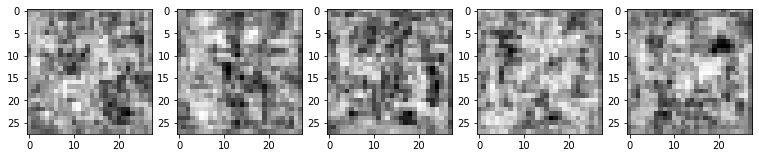

epoch: 0:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 0
Avg Training Disc Loss : 0.008464899580329744
Avg Training Gen Loss : 0.022486610034895525




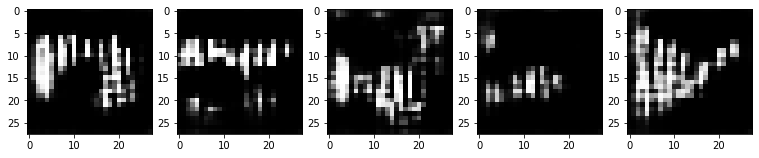

epoch: 1:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 1
Avg Training Disc Loss : 0.008743954156880512
Avg Training Gen Loss : 0.02217302307393125




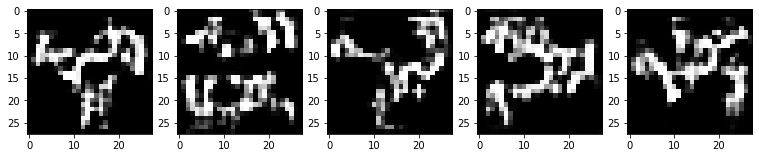

epoch: 2:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 2
Avg Training Disc Loss : 0.008708672747155269
Avg Training Gen Loss : 0.022635145295747332




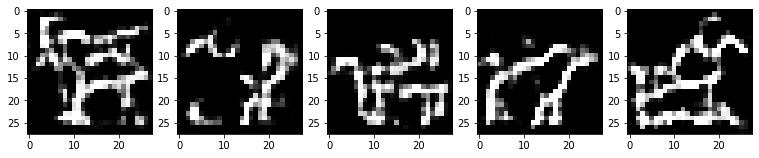

epoch: 3:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 3
Avg Training Disc Loss : 0.008873292714479385
Avg Training Gen Loss : 0.0225803304342506




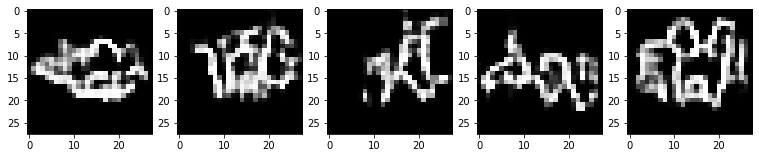

epoch: 4:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 4
Avg Training Disc Loss : 0.009056146263767897
Avg Training Gen Loss : 0.02235170858668482




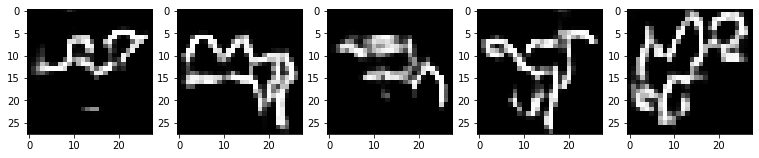

epoch: 5:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 5
Avg Training Disc Loss : 0.009062045166671749
Avg Training Gen Loss : 0.02315754972298305




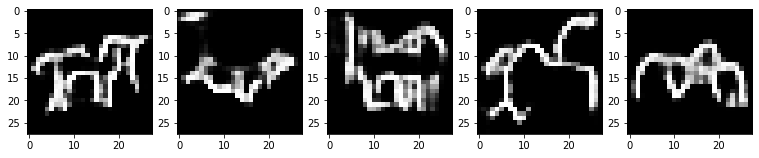

epoch: 6:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 6
Avg Training Disc Loss : 0.009014913420185065
Avg Training Gen Loss : 0.023872608252719137




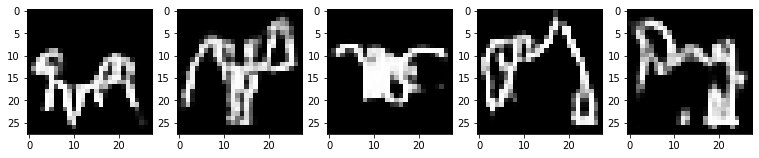

epoch: 7:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 7
Avg Training Disc Loss : 0.008953893738194238
Avg Training Gen Loss : 0.024541090380798943




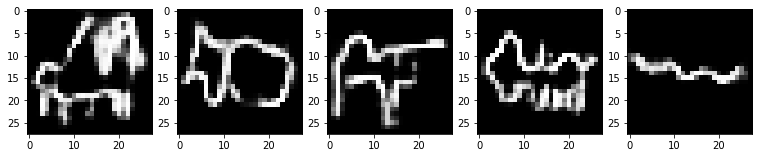

epoch: 8:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 8
Avg Training Disc Loss : 0.00885641797151425
Avg Training Gen Loss : 0.024896103999619803




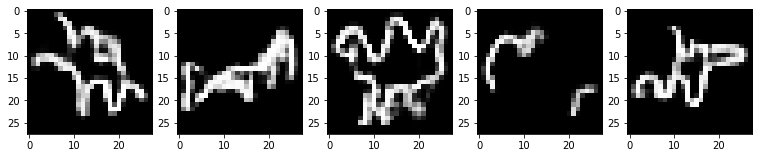

epoch: 9:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 9
Avg Training Disc Loss : 0.008774390003058795
Avg Training Gen Loss : 0.025240204941288733




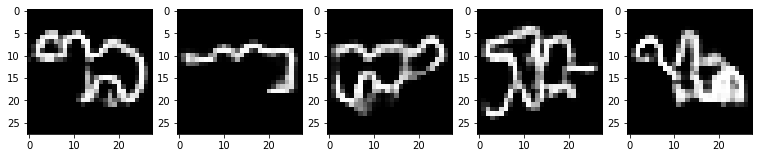

epoch: 10:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 10
Avg Training Disc Loss : 0.008723848033669563
Avg Training Gen Loss : 0.025020383081076444




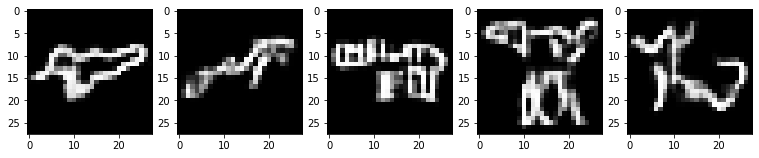

epoch: 11:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 11
Avg Training Disc Loss : 0.008696508607029398
Avg Training Gen Loss : 0.024964520064740373




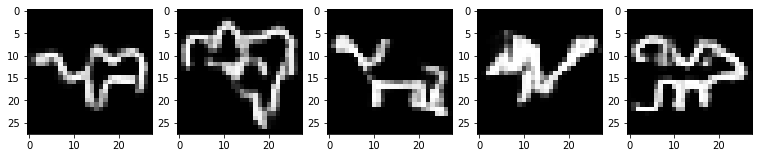

epoch: 12:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 12
Avg Training Disc Loss : 0.008636145484446595
Avg Training Gen Loss : 0.024697987857268046




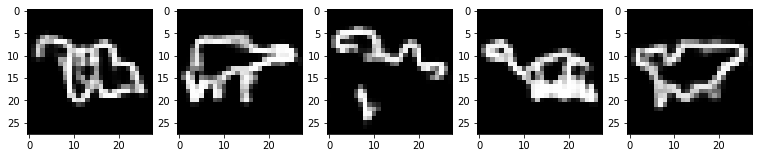

epoch: 13:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 13
Avg Training Disc Loss : 0.008628958288093893
Avg Training Gen Loss : 0.02440788119407565




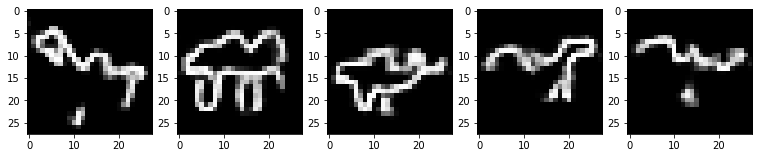

epoch: 14:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 14
Avg Training Disc Loss : 0.008601586196710077
Avg Training Gen Loss : 0.024401294097958208




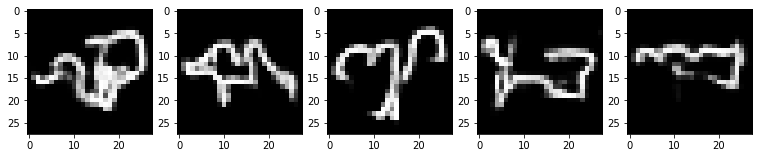

epoch: 15:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 15
Avg Training Disc Loss : 0.0085919354371207
Avg Training Gen Loss : 0.02423246142854388




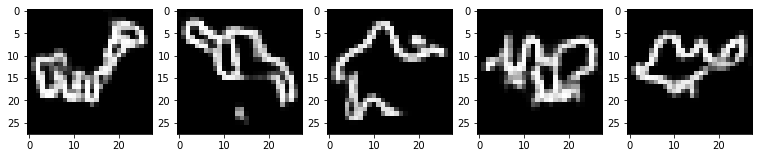

epoch: 16:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 16
Avg Training Disc Loss : 0.008632113503875995
Avg Training Gen Loss : 0.02391354909091374




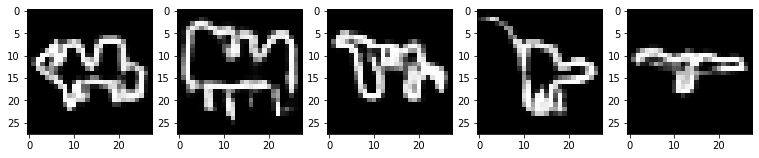

epoch: 17:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 17
Avg Training Disc Loss : 0.008616214247810162
Avg Training Gen Loss : 0.023964425011332547




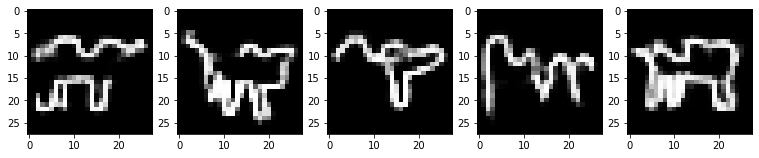

epoch: 18:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 18
Avg Training Disc Loss : 0.008621971383654625
Avg Training Gen Loss : 0.0239042661919808




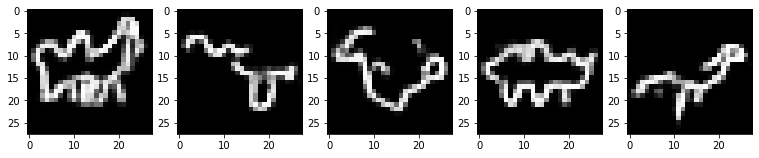

epoch: 19:   0%|          | 0/1897 [00:00<?, ?it/s]


Epoch: 19
Avg Training Disc Loss : 0.008624756895636307
Avg Training Gen Loss : 0.023619663911853283




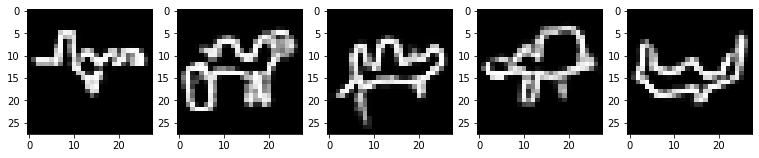

In [16]:
from torch.optim import Adam, RMSprop

def plot_images(gen_images, num_to_show=5):
  fig, ax = plt.subplots(1, num_to_show, figsize=(13,5))
  for i in range(num_to_show):
      ax[i].imshow(gen_images[i].squeeze(0).cpu().detach().numpy(), cmap='gray')
  plt.show()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
my_descriminator = my_discriminator.to(device)
my_generator = my_generator.to(device)


lr_disc=0.00002
optimizer_disc = Adam(my_descriminator.parameters(), lr=lr_disc)

lr_gen=0.00002
optimizer_gen = Adam(my_generator.parameters(), lr=lr_gen)

criterion_disc = nn.BCELoss()
criterion_gen = nn.BCELoss()
torch.random.manual_seed(10210)

epochs = 20
disc_batch_losses = []
disc_epoch_losses = []
gen_batch_losses = []
gen_epoch_losses = []
gen_images_epoch = []
x = torch.normal(mean=0, std=1, size=(10, gen_input_dim)).to(device)
gen_images_epoch.append(my_generator(x))
plot_images(gen_images_epoch[-1])

for e in range(epochs):
    
    progress_bar = tqdm(trn_dataloader, desc=f'epoch: {e}', leave=False, disable=False)
    loss_disc_total = 0
    loss_gen_total = 0

    for imgs in progress_bar:
        imgs = imgs.to(device)

        # train discriminator
        my_discriminator.train()

        y_hat_real = my_discriminator(imgs).to(device)
        y_real = torch.ones_like(y_hat_real).to(device)
        x = torch.normal(mean=0, std=1, size=(imgs.shape[0], gen_input_dim)).to(device)

        my_generator.eval()   # don't train generator
        with torch.no_grad():
            fake_images = my_generator(x)

        y_hat_fake = my_discriminator(fake_images).to(device)
        y_fake = torch.zeros_like(y_hat_fake).to(device)

        loss_disc = criterion_disc(torch.concat((y_hat_real, y_hat_fake), 0) , torch.concat((y_real, y_fake), 0))
        disc_batch_losses.append(loss_disc.item()) # average loss for batch
        loss_disc_total += loss_disc.item()        # running total across epoch

        my_discriminator.zero_grad()
        loss_disc.backward()
        optimizer_disc.step()

        # train generator
        my_generator.train()
        x = torch.normal(0,1, size=(imgs.shape[0], gen_input_dim)).to(device)
        fake_images = my_generator(x).to(device)

        my_discriminator.eval()

        y_hat_real = my_discriminator(fake_images)
        y_real = torch.ones_like(y_hat_real).to(device)


        loss_gen = criterion_gen(y_hat_real, y_real)
        gen_batch_losses.append(loss_gen.item())  # average loss for batch
        loss_gen_total += loss_gen.item()         # running total across epoch

        my_generator.zero_grad()
        my_discriminator.zero_grad()

        loss_gen.backward()
        optimizer_gen.step()

        
        progress_bar.set_postfix({
            'loss per image (disc)': '{:.3f}'.format(loss_disc.item()),
            'loss per image (gen)': '{:.3f}'.format(loss_gen.item())
        })

    disc_epoch_losses.append(loss_disc_total / len(trn_dataset))
    gen_epoch_losses.append(loss_gen_total / len(trn_dataset))
    tqdm.write(f'\nEpoch: {e}')
    tqdm.write(f'Avg Training Disc Loss : {disc_epoch_losses[-1]}')
    tqdm.write(f'Avg Training Gen Loss : {gen_epoch_losses[-1]}')
    tqdm.write('\n')

    # end of epoch, gen and save 10 random images
    x = torch.normal(mean=0, std=1, size=(10, gen_input_dim)).to(device)
    gen_images_epoch.append(my_generator(x))
    plot_images(gen_images_epoch[-1])



# Train Loss Curve

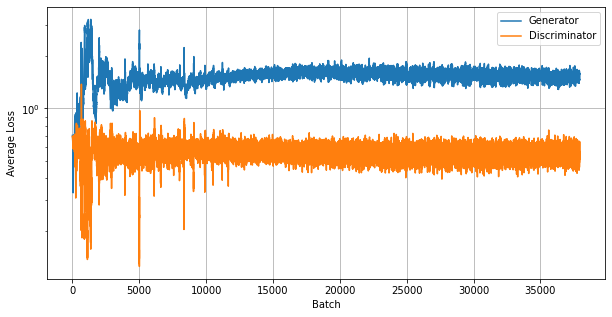

In [18]:
plt.figure(figsize=(10,5))
plt.semilogy(gen_batch_losses, label='Generator')
plt.semilogy(disc_batch_losses, label='Discriminator')
plt.xlabel('Batch')
plt.ylabel('Average Loss')
plt.grid()
plt.legend()
plt.show()

# Generated Images across epochs

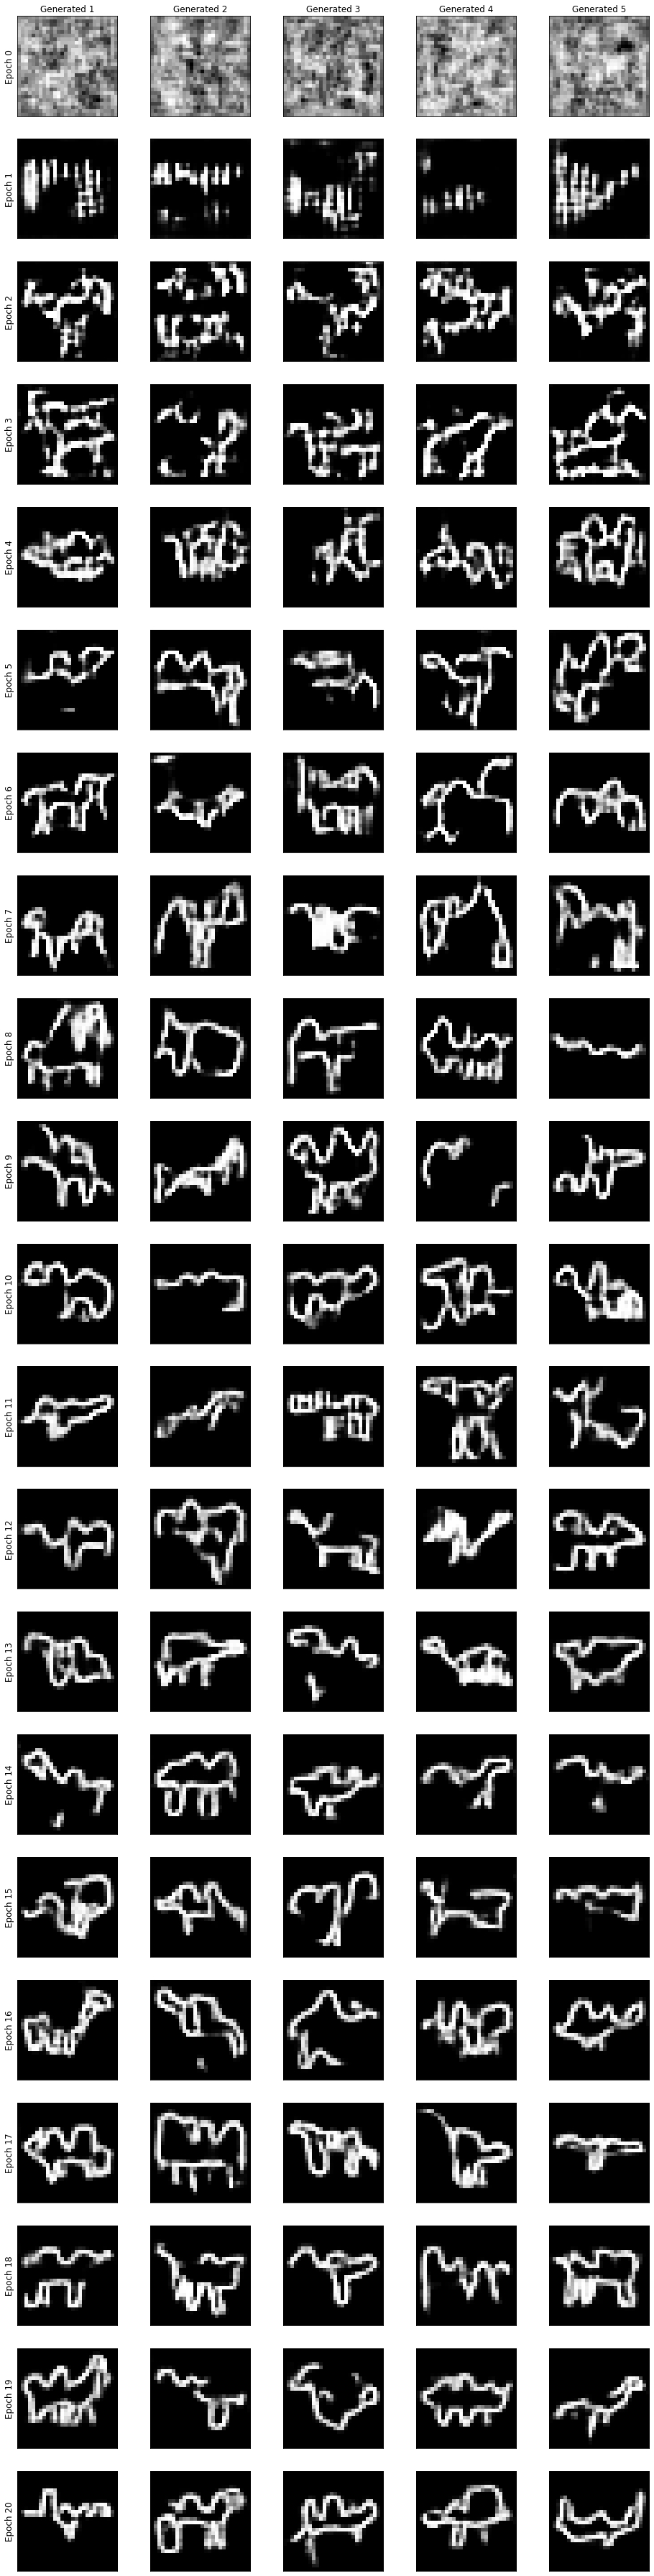

In [30]:
def plot_images_grid(gen_images, num_to_show=5):
  fig, ax = plt.subplots(len(gen_images), num_to_show, figsize=(13,50))
  fig.tight_layout()

  row_names = [f'Epoch {e}' for e in range(len(gen_images)+1)]
  col_names = [f'Generated {i+1}' for i in range(num_to_show)]
  for a, r in zip(ax[:,0], row_names):
      a.set_ylabel(r, rotation=90, size='large')
  for a, c in zip(ax[0], col_names):
    a.set_title(c)

  for e in range(len(gen_images)):
      for i in range(num_to_show):
          ax[e, i].imshow(gen_images[e][i].squeeze(0).cpu().detach().numpy(), cmap='gray')
          ax[e, i].set_xticks([])
          ax[e, i].set_yticks([])
  
  plt.show()  


plot_images_grid(gen_images_epoch)

# Save/Load the model

In [31]:
from google.colab import drive
drive.mount('/content/drive/')

torch.save(my_discriminator.state_dict(), '/content/drive/My Drive/Models/GANimals_discriminator_epoch20.model')
torch.save(my_generator.state_dict(), '/content/drive/My Drive/Models/GANimals_generator_epoch20.model')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [32]:
from google.colab import drive
drive.mount('/content/drive/')

disc_conv_filters = [5,5,5,5]
disc_conv_strides = [2,2,2,1]
disc_conv_channels = [64, 64, 128, 128]
disc_conv_padding = [2,1,1,1]
dropout=0.4
disc_in_channels=1
torch.random.manual_seed(10210)

my_discriminator = Discriminator(in_channels=disc_in_channels, 
                                 out_channels=disc_conv_channels, 
                                 disc_conv_filters=disc_conv_filters, 
                                 disc_conv_strides=disc_conv_strides,
                                 disc_conv_padding=disc_conv_padding, 
                                 dropout=dropout)

my_discriminator.load_state_dict(torch.load('/content/drive/My Drive/Models/GANimals_discriminator_epoch20.model', map_location=torch.device('cpu')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_discriminator = my_discriminator.to(device)


gen_conv_filters = [5,5,5,5]
gen_conv_strides = [1,1,1,1]
gen_conv_channels = [128,64,64,1]
gen_conv_padding = [2,2,2,2]
gen_upsample=[2,2,1,1]
gen_dropout=0.4
gen_input_dim=100
gen_momentum=0.9
gen_initial_size=7
torch.random.manual_seed(10210)
my_generator = Generator(input_dim=gen_input_dim, 
                         gen_conv_filters=gen_conv_filters, 
                         gen_conv_strides=gen_conv_strides, 
                         gen_conv_channels=gen_conv_channels, 
                         gen_conv_padding=gen_conv_padding, 
                         gen_upsample=gen_upsample,
                         dropout=gen_dropout,
                         momentum=gen_momentum,
                         initial_image_size=gen_initial_size)


my_generator.load_state_dict(torch.load('/content/drive/My Drive/Models/GANimals_generator_epoch20.model', map_location=torch.device('cpu')))
my_generator = my_generator.to(device)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
